In [95]:
import pandas as pd
import numpy as np
import os, json, re, glob
from os.path import join
from netneurotools import datasets as nntdata
from neuromaps.parcellate import Parcellater

from nilearn import image, plotting
from surfplot import Plot

from neuromaps.datasets import fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti



# gradient color bar
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import seaborn as sns

## functin: gradient color bar

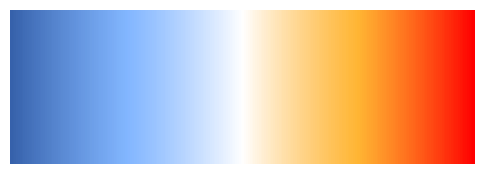

In [96]:
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


# gradient


# function for brain plot

In [97]:
# %%


def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()


## stack xcorr data

In [100]:
xcorr_dir = '/Volumes/spacetop_projects_cue/analysis/physio/xcorr_noZ'

all_frames = []  

for filename in os.listdir(xcorr_dir):
    if filename.endswith('.tsv'):  # Assuming the files are CSVs
        file_path = os.path.join(xcorr_dir, filename)
        df = pd.read_csv(file_path, sep='\t')
        all_frames.append(df)
combined_df = pd.concat(all_frames, ignore_index=True)
combined_df.to_csv(join(xcorr_dir, 'sub-all_runtype-pain_xcorr-fmri-physio.tsv'), sep='\t', index=False)


In [101]:

df = combined_df.drop(columns=['Unnamed: 0'])
df = df.dropna()
df.head()

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s)
0,sub-0061,ses-04,run-03,0.0,0.015488,-4.14
1,sub-0061,ses-04,run-03,1.0,0.010691,-10.12
2,sub-0061,ses-04,run-03,2.0,0.022655,27.14
3,sub-0061,ses-04,run-03,3.0,0.020641,20.24
4,sub-0061,ses-04,run-03,4.0,0.018622,19.32


min: -0.0367533419708156, max:0.390346686211373


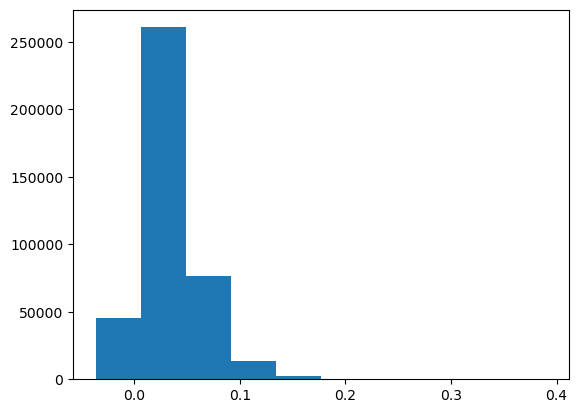

In [102]:
plt.hist(df['Maximum Correlation Value'])
print(f"min: {df['Maximum Correlation Value'].min()}, max:{df['Maximum Correlation Value'].max()}")

## fisher z transform

In [103]:
def fisher_z_transform(r):
    return np.arctanh(r)

df['Max_Corr_Value_Z'] = df['Maximum Correlation Value'].apply(fisher_z_transform)


## calculate summary statistics
here, I average Maximum corr values, time lags 
* first by calculating 1) within runs, 
* then 2) aggregating corr values, time lags per roi averaged within subs, 
* then 3) group level stats per ROI

In [104]:
avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()
group_level_avg = avg_per_sub.groupby('roi').median().reset_index()
group_level_avg['Avg_Max_Corr_Value'] = np.tanh(group_level_avg['Max_Corr_Value_Z'])


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_32654/1821671097.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_ses = df.groupby(['sub', 'ses', 'roi']).median().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_32654/1821671097.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_per_sub = avg_per_ses.groupby(['sub', 'roi']).median().reset_index()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_32654/1821671097.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only wil

In [105]:
df.head()

,sub,ses,run,roi,Maximum Correlation Value,Time Lag (s),Max_Corr_Value_Z
0,sub-0061,ses-04,run-03,0.0,0.015488,-4.14,0.015490
1,sub-0061,ses-04,run-03,1.0,0.010691,-10.12,0.010691
2,sub-0061,ses-04,run-03,2.0,0.022655,27.14,0.022659
3,sub-0061,ses-04,run-03,3.0,0.020641,20.24,0.020644
4,sub-0061,ses-04,run-03,4.0,0.018622,19.32,0.018624


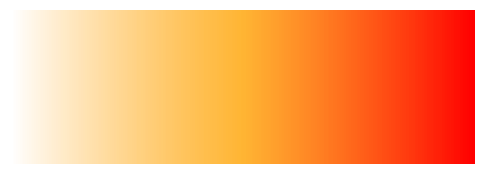

In [114]:
# Define the colors at specific points
colors = [
    # (-1, "#120041"),  # Start with blue at -1.9
    # (-0.8, "#2500fa"),
    # (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.01, "#d50044"),
    (0.02, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (0.03, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-1, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-0.8, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (.02, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (0.03, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0, .064, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
xcorr_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=xcorr_cmap)
ax.set_axis_off()

plt.show()


# plot X corr

(array([13., 23., 39., 51., 74., 94., 56., 31., 15.,  4.]),
 array([0.02170823, 0.02339818, 0.02508812, 0.02677807, 0.02846801,
        0.03015796, 0.0318479 , 0.03353785, 0.0352278 , 0.03691774,
        0.03860769]),
 <BarContainer object of 10 artists>)

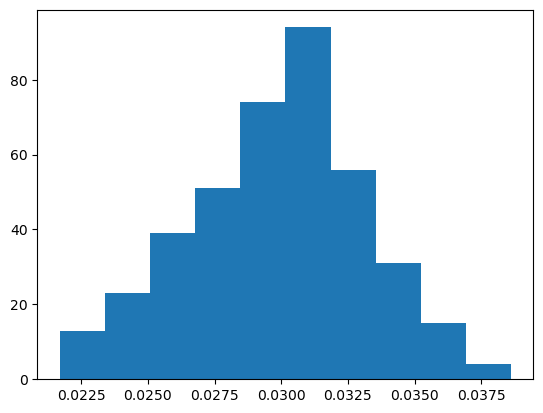

In [115]:
plt.hist(roi_xcorr)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


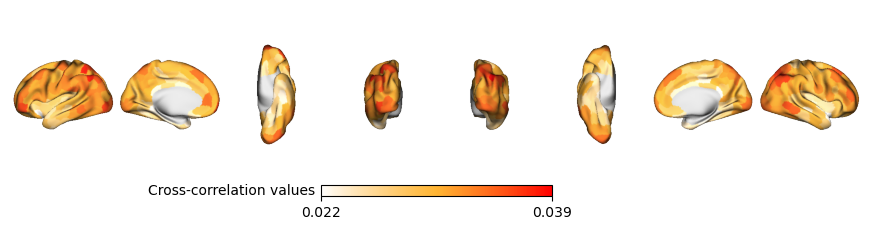

In [131]:
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_xcorr = group_level_avg['Avg_Max_Corr_Value']
roidata = parc.inverse_transform(roi_xcorr)

maxval = np.max(roi_xcorr);    minval = np.min(roi_xcorr); sd = np.std(roi_xcorr)
plot_brain_surfaces(image=roidata, cbar_label='Cross-correlation values', cmap=xcorr_cmap, color_range=(minval, maxval))
plt.show()

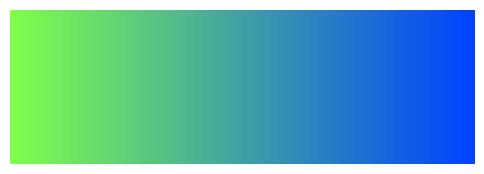

In [148]:
# Define the colors at specific points
colors = [
    # (-5.4, "#120041"),  # Start with blue at -1.9
    # (-3.6, "#2500fa"),
    # (-1.8, "#84c6fd"),  # Start with blue at -1.9
    (0, "#80ff4a"),    # Transition to white at 0
    # (4, "#fdbb2d"),
    # (5, "#09792c"),    # Start transitioning to red just after 0 towards 1.2
    (12, "#0043ff")  # End with yellow at 1.2
]

colors_with_opacity = [
    # (-5.4, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    # (-3.6, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("#80ff4a", alpha=1.0)),       # Fully opaque
    # (4, to_rgba("#fdbb2d", alpha=0.6)),   # 30% opacity
    # (6, to_rgba("#09792c", alpha=0.8)),   # 60% opacity
    (12, to_rgba("#0043ff", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(0,12, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
lag_cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=lag_cmap)
ax.set_axis_off()

plt.show()


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


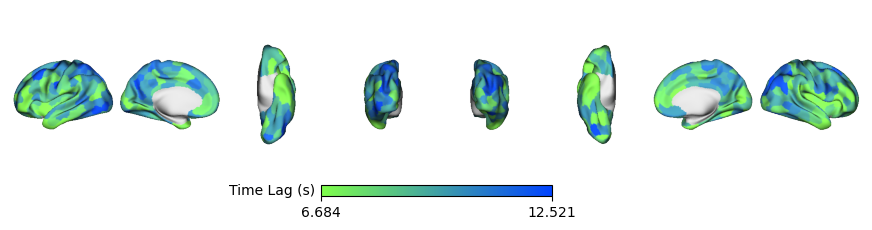

In [149]:
# xcorr_fname = 
# group_level_avg  =pd.read_csv(xcorr_fname, '\t')

schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
roi_timelag = group_level_avg['Time Lag (s)']
roidata = parc.inverse_transform(roi_timelag)

maxval = np.max(roi_timelag);    minval = np.min(roi_timelag); sd = np.std(roi_timelag)
plot_brain_surfaces(image=roidata, cbar_label='Time Lag (s)', cmap=lag_cmap, color_range=(minval+sd, maxval-sd))
plt.show()